# downloading the Dataset with kaggle file

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.16G/5.20G [00:18<00:00, 348MB/s]
100% 5.20G/5.20G [00:18<00:00, 301MB/s]


# unzipping the dataset file

In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: /content/data/ham10000_images_part_2/IS

# R2

# importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from sklearn.model_selection import train_test_split
import random

# loading the data

In [ ]:
base_skin_dir = os.path.join('..', '/content/data')


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# we created new columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# data preview

In [ ]:
# the updated data looks like this
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/data/ham10000_images_part_2/ISIC_0031...,Benign keratosis-like lesions,2


# checking the null values

In [ ]:
skin_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


**Interpretation:** the age seems to have the null values.

# solving the null values problem

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

<ipython-input-9-8b8ec19cc3cf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


In [ ]:
skin_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


**Interpretation:** we fill the null values by its mean values

# checking the datatype of dataset we have

In [ ]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


**Interpretation:** almost all columns are of object datatype. except for two columns 'age' and 'cell_type_idx'

# some visualization based EDA

<Axes: xlabel='cell_type'>

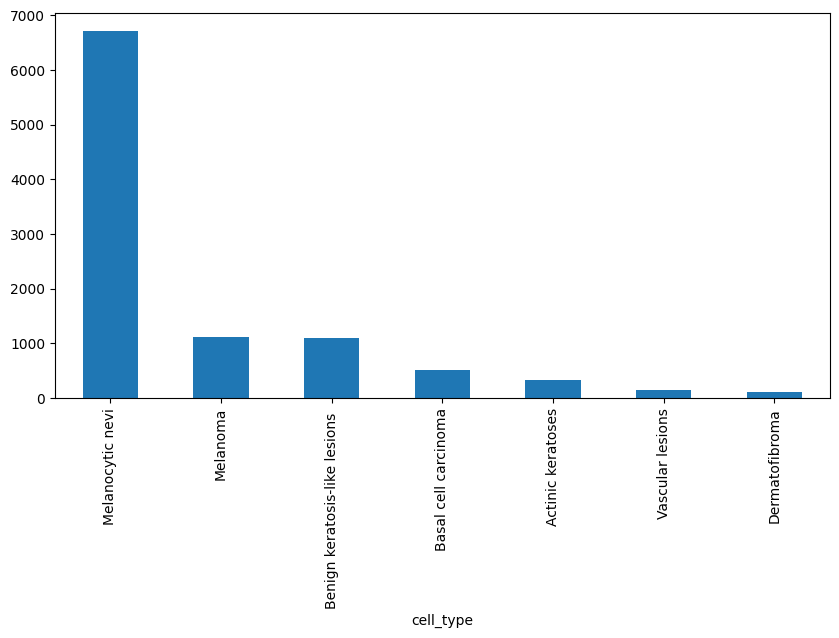

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

**interpretation:** dataset seems very imbalanced because nevi contains very much values in the dataset.

<Axes: xlabel='dx_type'>

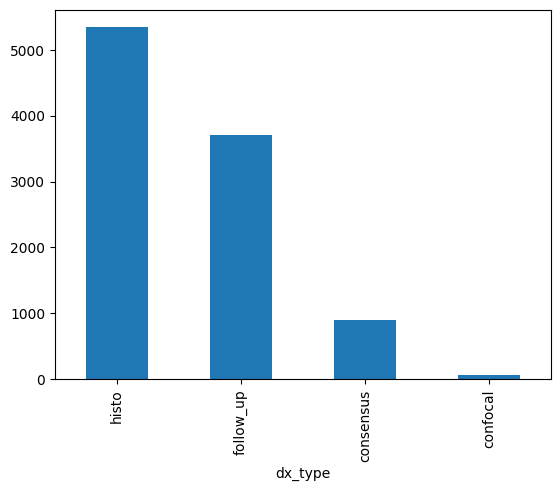

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: xlabel='localization'>

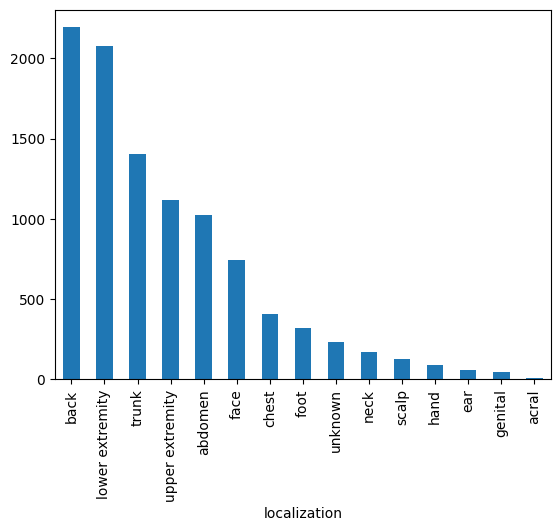

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

<Axes: >

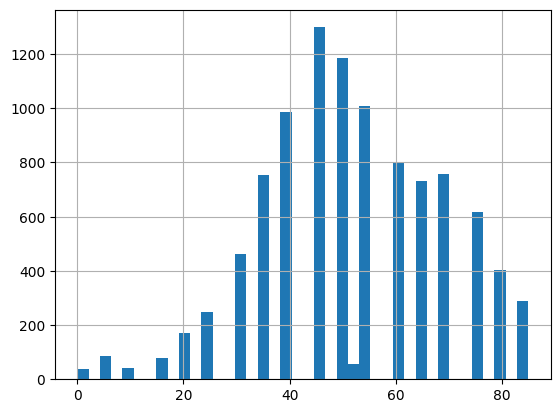

In [ ]:
skin_df['age'].hist(bins=40)

<Axes: xlabel='sex'>

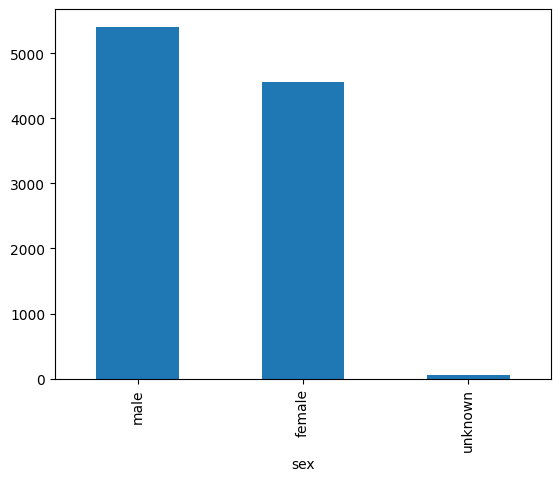

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')

# image preprocessing function

In [ ]:
#image preprocessing function with improved normalization
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.asarray(img, dtype=np.float32)

    #normalize to (0,1) range
    img_array = img_array / 255.0

    return img_array

# apply the preprocessing onto images
skin_df['image'] = skin_df['path'].map(lambda x: preprocess_image(x))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2,"[[[0.7411765, 0.59607846, 0.7607843], [0.75294..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2,"[[[0.09411765, 0.050980393, 0.08627451], [0.09..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2,"[[[0.73333335, 0.49803922, 0.5294118], [0.7450..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/data/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2,"[[[0.09411765, 0.043137256, 0.06666667], [0.09..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/data/ham10000_images_part_2/ISIC_0031...,Benign keratosis-like lesions,2,"[[[0.5058824, 0.34117648, 0.42745098], [0.5529..."


# displaying the sample of images we have.

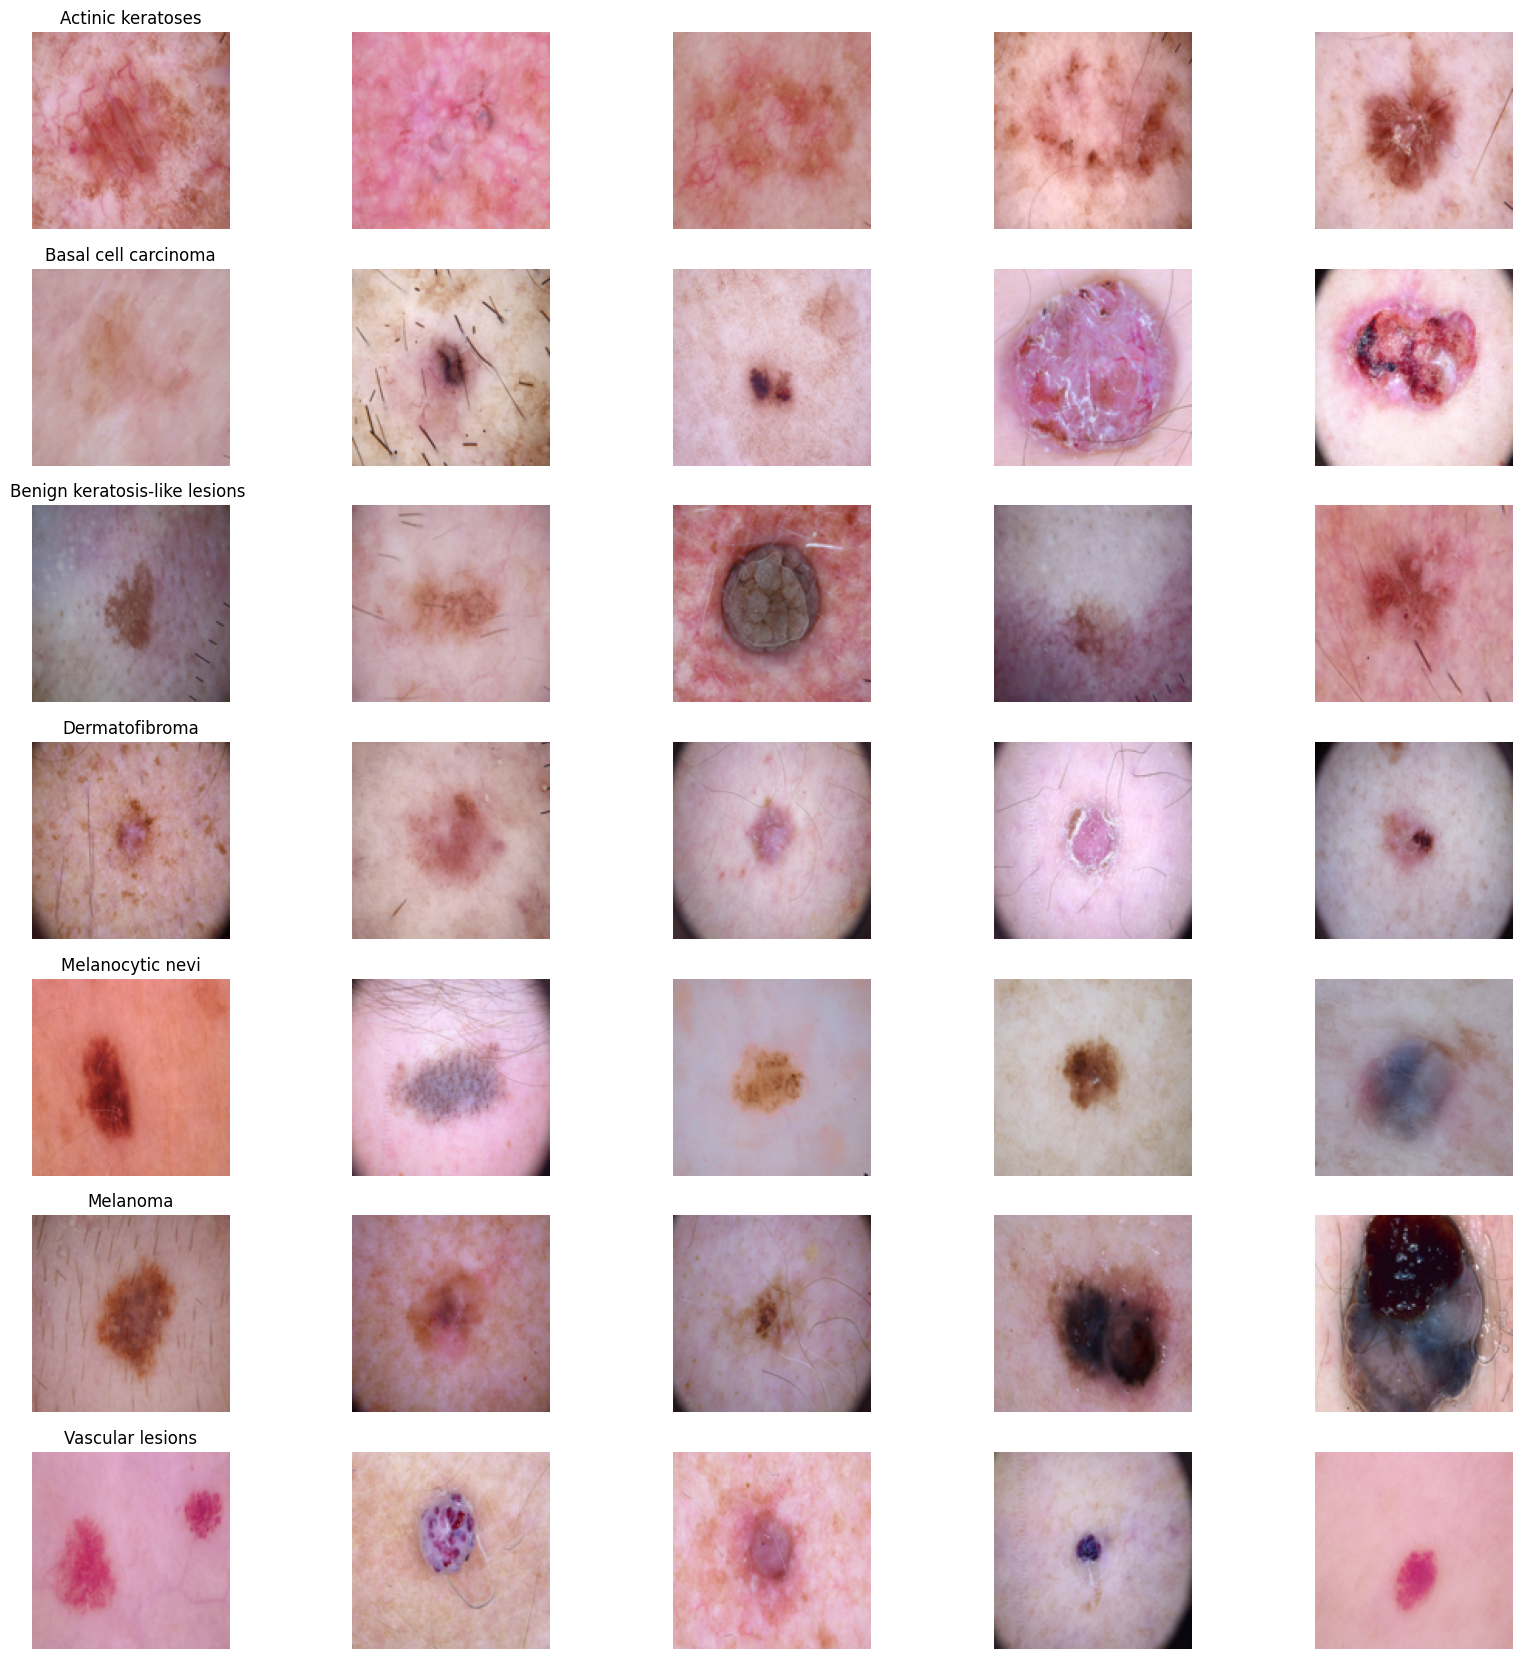

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# image size

In [ ]:
# checking the image sizes
skin_df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(128, 128, 3)",10015


**Interpretation:** we have resize our images to 128x128

# applying smote to deaL with class imbalancement.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import numpy as np
def apply_smote_to_images(X, y, target_size=(128, 128, 3)):
    """
    Apply SMOTE to image data by flattening, applying SMOTE, then reshaping back
    """
    print("Original class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for i, count in zip(unique, counts):
        print(f"Class {i}: {count} samples")

    #flatten images for smote
    X_flat = X.reshape(X.shape[0], -1)
    #apply smote with balanced strategy
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_resampled, y_resampled = smote.fit_resample(X_flat, y)

    #reshape back to image format
    X_resampled = X_resampled.reshape(-1, *target_size)

    print("\nAfter SMOTE class distribution:")
    unique, counts = np.unique(y_resampled, return_counts=True)
    for i, count in zip(unique, counts):
        print(f"Class {i}: {count} samples")

    return X_resampled, y_resampled

#extract features and target properly
X = np.array(skin_df['image'].tolist())
y = skin_df['cell_type_idx'].values
print(f"Original dataset shape: {X.shape}")
print(f"Original target shape: {y.shape}")

#apply SMOTE to balance the dataset
X_balanced, y_balanced = apply_smote_to_images(X, y)
print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Balanced target shape: {y_balanced.shape}")


Original dataset shape: (10015, 128, 128, 3)
Original target shape: (10015,)
Original class distribution:
Class 0: 327 samples
Class 1: 514 samples
Class 2: 1099 samples
Class 3: 115 samples
Class 4: 6705 samples
Class 5: 1113 samples
Class 6: 142 samples

After SMOTE class distribution:
Class 0: 6705 samples
Class 1: 6705 samples
Class 2: 6705 samples
Class 3: 6705 samples
Class 4: 6705 samples
Class 5: 6705 samples
Class 6: 6705 samples
Balanced dataset shape: (46935, 128, 128, 3)
Balanced target shape: (46935,)


# dividing our dataset into target and festures.

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

**interpretation:** we are dividing our dataset into features and target variables.

# function for plotting model history.

In [ ]:
#function to plot model validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('Epoch')
    num_epochs = len(model_history.history['accuracy'])
    axs[0].set_xticks(np.linspace(1, num_epochs, min(num_epochs, 10), dtype=int)) # Show up to 10 ticks
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.linspace(1, num_epochs, min(num_epochs, 10), dtype=int)) # Show up to 10 ticks
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Train and test split.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


# Use the balanced dataset for train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.20,
    random_state=1234,
    stratify=y_balanced
)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Image value range: {x_train.min():.3f} to {x_train.max():.3f}")

Training set shape: (37548, 128, 128, 3)
Test set shape: (9387, 128, 128, 3)
Image value range: 0.000 to 1.000


# implementation for R3 and R4

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# calculating each class weights after balancing the dataset.

In [ ]:
#calculate class weights for imbalanced classes
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0)}


In [ ]:
#convert to categorical for neural networks
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)
print(f"number of classes: {num_classes}")
print(f"training set shape: {x_train.shape}")
print(f"test set shape: {x_test.shape}")

number of classes: 7
training set shape: (37548, 128, 128, 3)
test set shape: (9387, 128, 128, 3)


# baseline training and evaluation experiments

In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(f"Flattened training shape: {x_train_flat.shape}")
print(f"Flattened test shape: {x_test_flat.shape}")

Flattened training shape: (37548, 49152)
Flattened test shape: (9387, 49152)


# model training

**decision tree:**

In [ ]:
#dictionary to store model results
model_results = {}
# 1. decision tree
print("1. training decision tree classifier")
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10)
dt_classifier.fit(x_train_flat, y_train)
dt_pred = dt_classifier.predict(x_test_flat)

#calculate metrics
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred, average='weighted')
dt_recall = recall_score(y_test, dt_pred, average='weighted')
dt_f1 = f1_score(y_test, dt_pred, average='weighted')

model_results['Decision Tree'] = {
    'accuracy': dt_accuracy,
    'precision': dt_precision,
    'recall': dt_recall,
    'f1_score': dt_f1
}

print(f"decision tree accuracy: {dt_accuracy:.4f}, f1-Score: {dt_f1:.4f}")

1. training decision tree classifier
decision tree accuracy: 0.7368, f1-Score: 0.7345


**naive bayes**

In [ ]:
# 2. naive bayes
print("2. training naive bayes classifier")
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_flat, y_train)
nb_pred = nb_classifier.predict(x_test_flat)

nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred, average='weighted')
nb_recall = recall_score(y_test, nb_pred, average='weighted')
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

model_results['Naive Bayes'] = {
    'accuracy': nb_accuracy,
    'precision': nb_precision,
    'recall': nb_recall,
    'f1_score': nb_f1
}

print(f"naive Bayes accuracy: {nb_accuracy:.4f}, f1-Score: {nb_f1:.4f}")

2. training naive bayes classifier
naive Bayes accuracy: 0.3800, f1-Score: 0.3825


**logistic regression**

In [ ]:
# 3. logistic regression
print("3. training logistic regression")
lr_classifier = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
lr_classifier.fit(x_train_flat, y_train)
lr_pred = lr_classifier.predict(x_test_flat)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

model_results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1
}

print(f"logistic regression accuracy: {lr_accuracy:.4f}, f1-Score: {lr_f1:.4f}")

3. training logistic regression
logistic regression accuracy: 0.9243, f1-Score: 0.9225


**knn**

In [ ]:
# 4. k-nearest neighbors
print("4. training knn")
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train_flat, y_train)
knn_pred = knn_classifier.predict(x_test_flat)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred, average='weighted')
knn_recall = recall_score(y_test, knn_pred, average='weighted')
knn_f1 = f1_score(y_test, knn_pred, average='weighted')

model_results['K-NN'] = {
    'accuracy': knn_accuracy,
    'precision': knn_precision,
    'recall': knn_recall,
    'f1_score': knn_f1
}

print(f"knn accuracy: {knn_accuracy:.4f}, f1-Score: {knn_f1:.4f}")


4. training knn
knn accuracy: 0.9384, f1-Score: 0.9328


# ml model comparison

                     accuracy  precision  recall  f1_score
Decision Tree          0.7368     0.7385  0.7368    0.7345
Naive Bayes            0.3800     0.4050  0.3800    0.3825
Logistic Regression    0.9243     0.9234  0.9243    0.9225
K-NN                   0.9384     0.9430  0.9384    0.9328


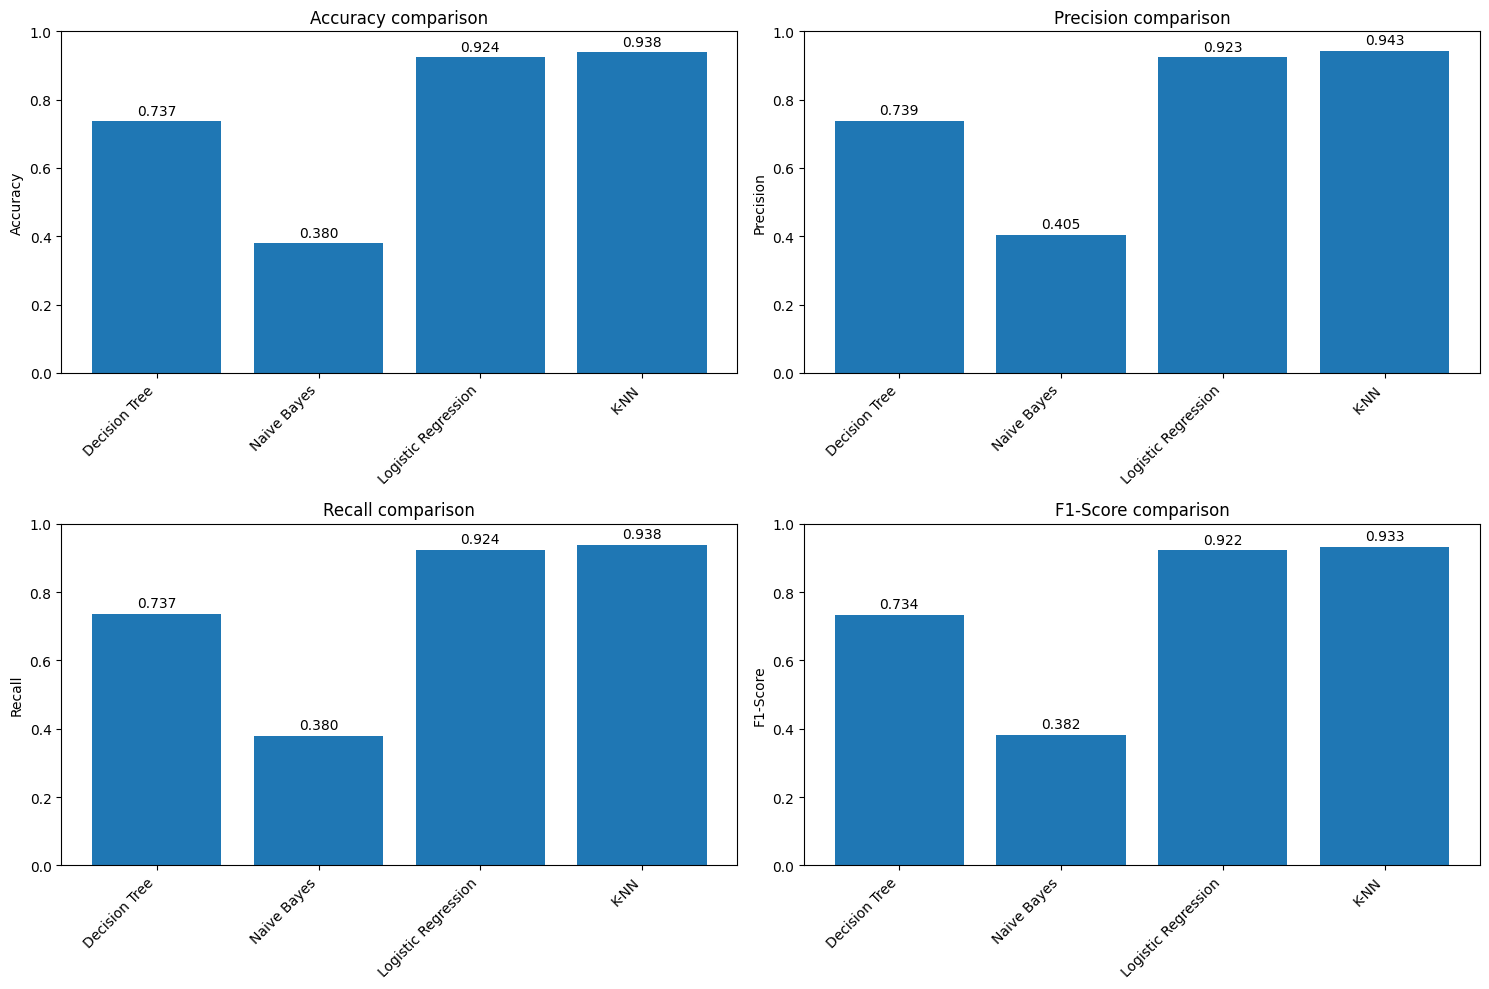

In [ ]:
# display comparison of all baseline models
results_df = pd.DataFrame(model_results).T
print(results_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i%2]
    values = [model_results[model][metric] for model in model_results.keys()]
    bars = ax.bar(model_results.keys(), values)
    ax.set_title(f'{title} comparison')
    ax.set_ylabel(title)
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('baseline_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

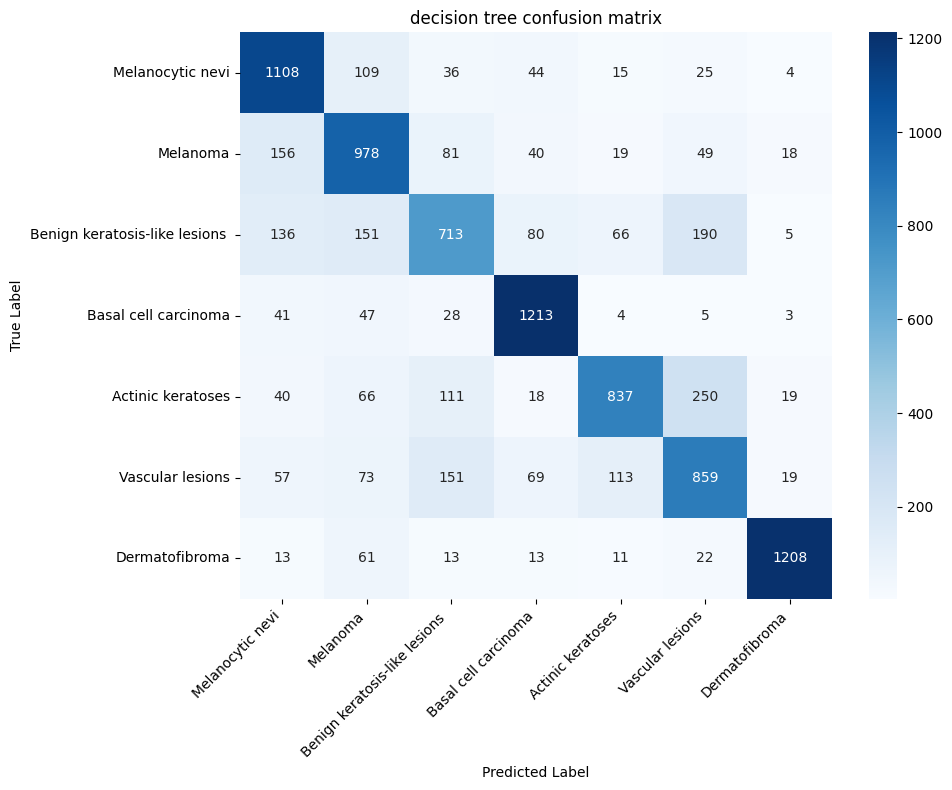

In [ ]:
# plot confusion matrix for Decision Tree
plt.figure(figsize=(10, 8))
dt_cm = confusion_matrix(y_test, dt_pred)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lesion_type_dict.values(),
            yticklabels=lesion_type_dict.values())
plt.title('decision tree confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('decision_tree_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# confusion matrix for best performing model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
print(f"best performing baseline model: {best_model_name}")

best performing baseline model: K-NN


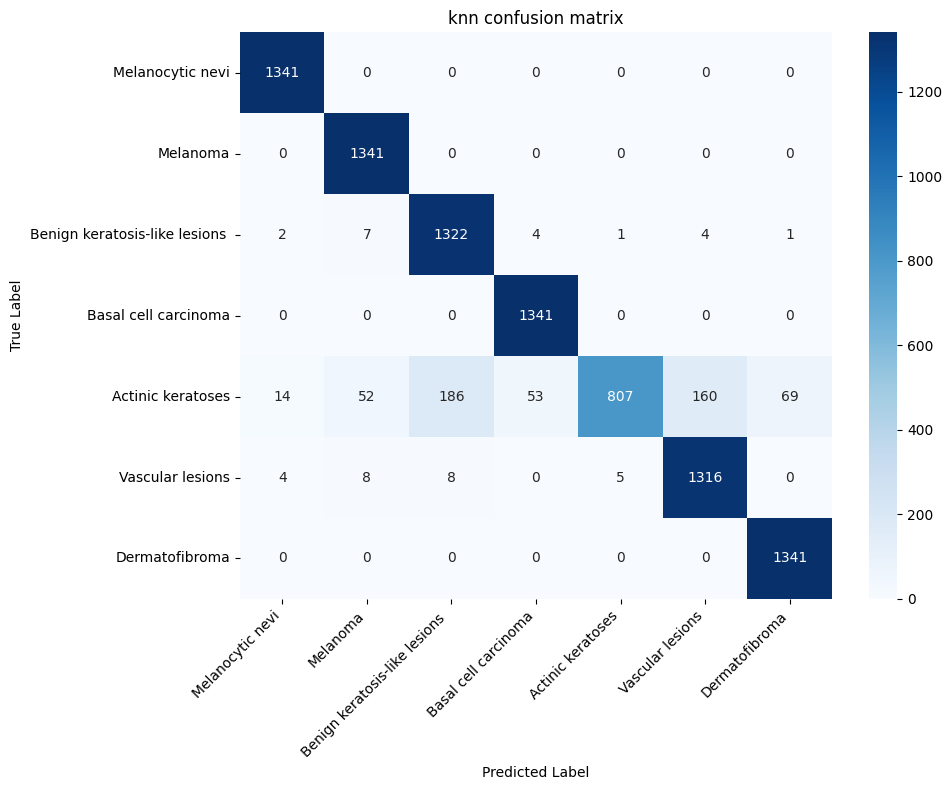

In [ ]:
# plot confusion matrix for KNN
plt.figure(figsize=(10, 8))
knn_cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lesion_type_dict.values(),
            yticklabels=lesion_type_dict.values())
plt.title('knn confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# neural networks implementation

**mlp**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Store neural network results
nn_results = {}

# 1. MLP
print("1. training multilayer perceptron")

# Build MLP model
mlp_model = Sequential([
    # Change the input_shape in Flatten to match the actual image size (128, 128, 3)
    Flatten(input_shape=(128, 128, 3)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("mlp model architecture:")
mlp_model.summary()

1. training multilayer perceptron
mlp model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,334,535 (96.64 MB)

 Trainable params: 25,332,999 (96.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

mlp_history = mlp_model.fit(x_train, y_train_cat,
                           batch_size=32,
                           epochs=20,
                           validation_split=0.2,
                           callbacks=[reduce_lr],
                           verbose=1)

Epoch 1/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2966 - loss: 2.0320 - val_accuracy: 0.1956 - val_loss: 3.5195 - learning_rate: 0.0010
Epoch 2/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4278 - loss: 1.4739 - val_accuracy: 0.1788 - val_loss: 7.6575 - learning_rate: 0.0010
Epoch 3/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4394 - loss: 1.4380 - val_accuracy: 0.1959 - val_loss: 4.3964 - learning_rate: 0.0010
Epoch 4/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4171 - loss: 1.4913 - val_accuracy: 0.1470 - val_loss: 4.9972 - learning_rate: 0.0010
Epoch 5/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3472 - loss: 1.6113 - val_accuracy: 0.2253 - val_loss: 2.1002 - learning_rate: 0.0010
Epoch 6/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3267 - loss: 1.6110 - val_accuracy: 0.3240 - val_loss: 1.6119 - learning_rate: 0.0010
Epoch 7/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3396 - loss: 1.5540 

In [ ]:
#evaluate MLP
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(x_test, y_test_cat, verbose=0)
mlp_pred_proba = mlp_model.predict(x_test)
mlp_pred = np.argmax(mlp_pred_proba, axis=1)

mlp_precision = precision_score(y_test, mlp_pred, average='weighted')
mlp_recall = recall_score(y_test, mlp_pred, average='weighted')
mlp_f1 = f1_score(y_test, mlp_pred, average='weighted')

nn_results['MLP'] = {
    'accuracy': mlp_test_acc,
    'precision': mlp_precision,
    'recall': mlp_recall,
    'f1_score': mlp_f1
}

print(f"mlp test accuracy: {mlp_test_acc:.4f}, f1-Score: {mlp_f1:.4f}")

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
mlp test accuracy: 0.1432, f1-Score: 0.0364


**CNN**

In [ ]:
# 2. CNN
print("2. training convolutional neural network")

# build cnn model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("cnn model architecture:")
cnn_model.summary()

2. training convolutional neural network
cnn model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,244,615 (20.01 MB)

 Trainable params: 5,242,631 (20.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# train CNN
cnn_history = cnn_model.fit(x_train, y_train_cat,
                           batch_size=32,
                           epochs=20,
                           validation_split=0.2,
                           callbacks=[reduce_lr],
                           verbose=1)

Epoch 1/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.4864 - loss: 1.6672 - val_accuracy: 0.6352 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 2/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7189 - loss: 0.7679 - val_accuracy: 0.8387 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 3/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8007 - loss: 0.5411 - val_accuracy: 0.4712 - val_loss: 1.8333 - learning_rate: 0.0010
Epoch 4/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8547 - loss: 0.3841 - val_accuracy: 0.8569 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 5/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8858 - loss: 0.3118 - val_accuracy: 0.7125 - val_loss: 2.2370 - learning_rate: 0.0010
Epoch 6/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9066 - loss: 0.2654 - val_accuracy: 0.8142 - val_loss: 0.5254 - learning_rate: 0.0010
Epoch 7/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9166 - l

In [ ]:
#evaluate CNN
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test, y_test_cat, verbose=0)
cnn_pred_proba = cnn_model.predict(x_test)
cnn_pred = np.argmax(cnn_pred_proba, axis=1)

cnn_precision = precision_score(y_test, cnn_pred, average='weighted')
cnn_recall = recall_score(y_test, cnn_pred, average='weighted')
cnn_f1 = f1_score(y_test, cnn_pred, average='weighted')

nn_results['CNN'] = {
    'accuracy': cnn_test_acc,
    'precision': cnn_precision,
    'recall': cnn_recall,
    'f1_score': cnn_f1
}

print(f"cnn test accuracy: {cnn_test_acc:.4f}, f1 score: {cnn_f1:.4f}")

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
cnn test accuracy: 0.9503, f1 score: 0.9491


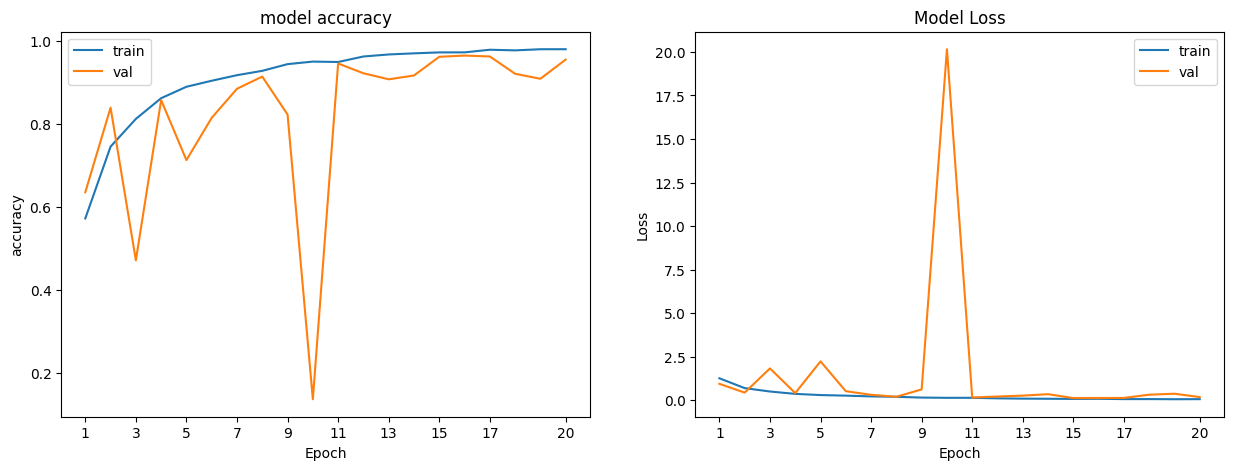

In [ ]:
# cnn training history
plot_model_history(cnn_history)

# comparison of ml and deep learning based models.

In [ ]:
# results comparison

#combine all results
all_results = {**model_results, **nn_results}
final_results_df = pd.DataFrame(all_results).T
print(final_results_df.round(4))

                     accuracy  precision  recall  f1_score
Decision Tree          0.7368     0.7385  0.7368    0.7345
Naive Bayes            0.3800     0.4050  0.3800    0.3825
Logistic Regression    0.9243     0.9234  0.9243    0.9225
K-NN                   0.9384     0.9430  0.9384    0.9328
MLP                    0.1432     0.3061  0.1432    0.0364
CNN                    0.9503     0.9505  0.9503    0.9491


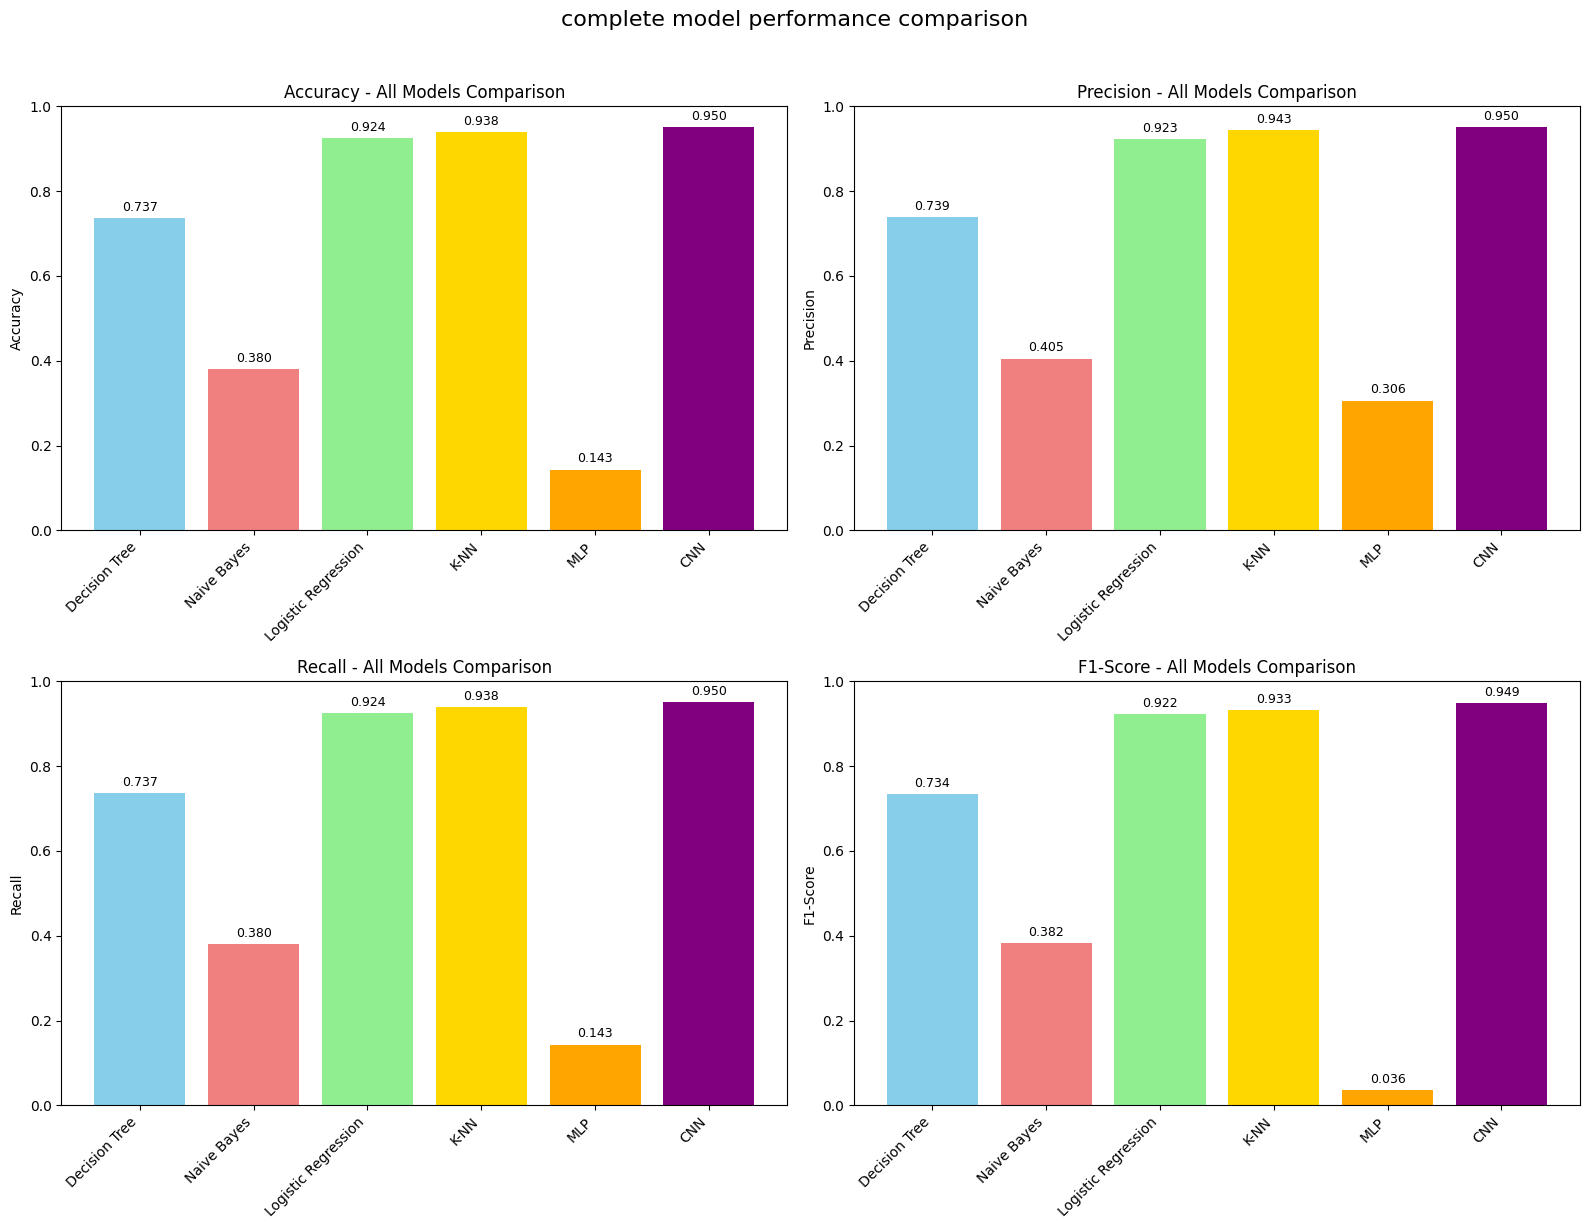

In [ ]:
# visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i%2]
    values = [all_results[model][metric] for model in all_results.keys()]
    bars = ax.bar(all_results.keys(), values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange', 'purple'])
    ax.set_title(f'{title} - All Models Comparison')
    ax.set_ylabel(title)
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('complete model performance comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('complete_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# find and display best model
best_overall_model = max(all_results.keys(), key=lambda k: all_results[k]['f1_score'])
print(f"best overall model (f1-Score): {best_overall_model}")
print(f"f1-Score: {all_results[best_overall_model]['f1_score']:.4f}")
print(f"accuracy: {all_results[best_overall_model]['accuracy']:.4f}")

best overall model (f1-Score): CNN
f1-Score: 0.9491
accuracy: 0.9503


In [ ]:
# classification report for best neural network model
best_nn_model = max(nn_results.keys(), key=lambda k: nn_results[k]['f1_score'])
if best_nn_model == 'CNN':
    best_pred = cnn_pred
else:
    best_pred = mlp_pred

print(f"detailed classification report of {best_nn_model}:")
print(classification_report(y_test, best_pred, target_names=list(lesion_type_dict.values())))

detailed classification report of CNN:
                                precision    recall  f1-score   support

              Melanocytic nevi       0.93      1.00      0.96      1341
                      Melanoma       0.97      0.99      0.98      1341
Benign keratosis-like lesions        0.91      0.94      0.93      1341
          Basal cell carcinoma       1.00      1.00      1.00      1341
             Actinic keratoses       0.94      0.79      0.86      1341
              Vascular lesions       0.91      0.94      0.92      1341
                Dermatofibroma       0.99      1.00      1.00      1341

                      accuracy                           0.95      9387
                     macro avg       0.95      0.95      0.95      9387
                  weighted avg       0.95      0.95      0.95      9387



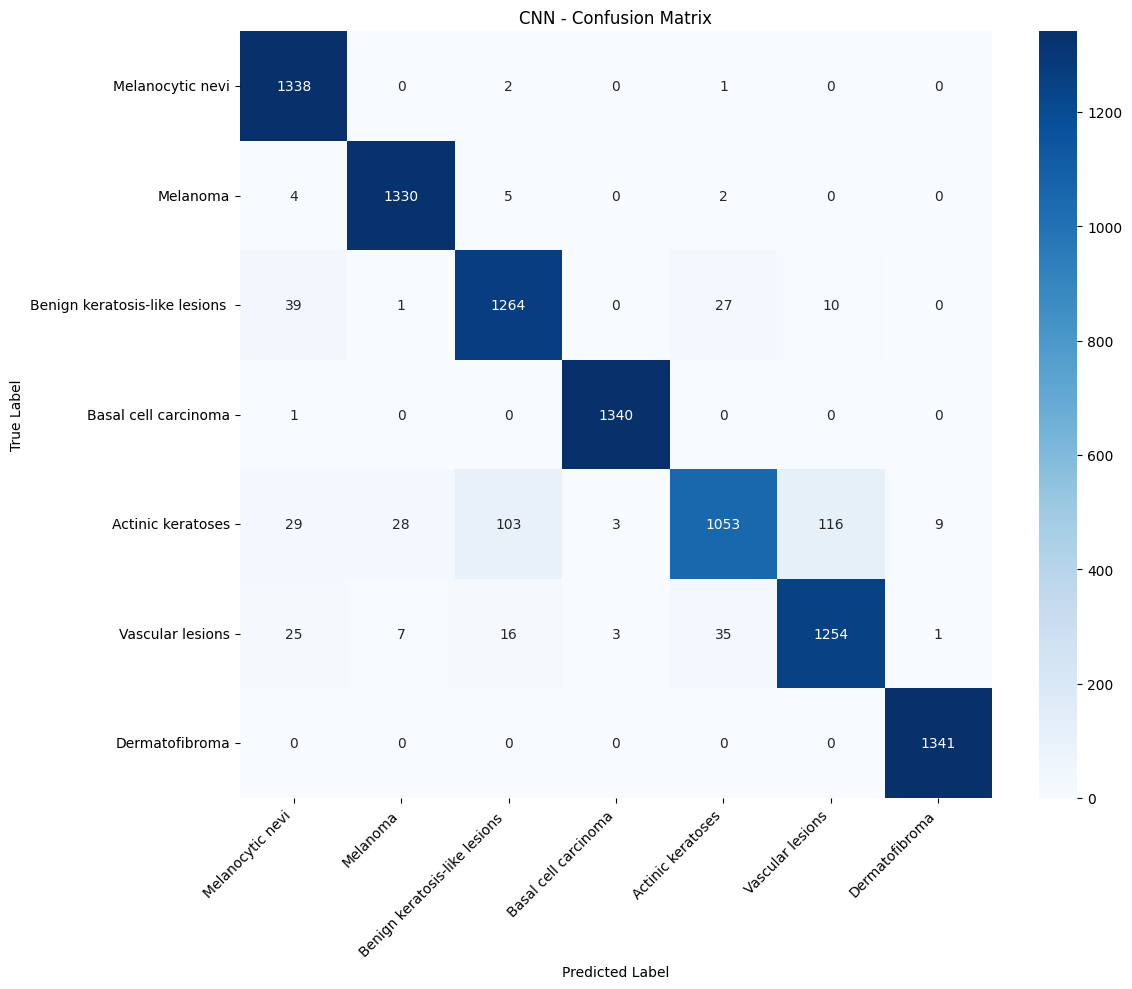

In [ ]:
# confusion matrix for best neural network model
plt.figure(figsize=(12, 10))
nn_cm = confusion_matrix(y_test, best_pred)
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(lesion_type_dict.values()),
            yticklabels=list(lesion_type_dict.values()))
plt.title(f'{best_nn_model} - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{best_nn_model.lower()}_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#performance analysis by lesion type

In [ ]:
#calculate perclass metrics for the best model
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, best_pred, target_names=list(lesion_type_dict.values()), output_dict=True)

class_performance = pd.DataFrame({
    'Precision': [report_dict[class_name]['precision'] for class_name in lesion_type_dict.values()],
    'Recall': [report_dict[class_name]['recall'] for class_name in lesion_type_dict.values()],
    'F1-Score': [report_dict[class_name]['f1-score'] for class_name in lesion_type_dict.values()],
    'Support': [report_dict[class_name]['support'] for class_name in lesion_type_dict.values()]
}, index=list(lesion_type_dict.values()))

print("per class Performance (best model):")
print(class_performance.round(3))

per class Performance (best model):
                                Precision  Recall  F1-Score  Support
Melanocytic nevi                    0.932   0.998     0.964   1341.0
Melanoma                            0.974   0.992     0.983   1341.0
Benign keratosis-like lesions       0.909   0.943     0.926   1341.0
Basal cell carcinoma                0.996   0.999     0.997   1341.0
Actinic keratoses                   0.942   0.785     0.856   1341.0
Vascular lesions                    0.909   0.935     0.922   1341.0
Dermatofibroma                      0.993   1.000     0.996   1341.0


# saving the trained models

In [ ]:
#save models for potential gui implementation (bonus feature)
print("saving trained models")
cnn_model.save('skin_cancer_cnn_model.h5')
mlp_model.save('skin_cancer_mlp_model.h5')

saving trained models


In [ ]:
#save preprocessing parameters
import pickle

preprocessing_params = {
    'train_mean': np.mean(x_train), # calculate mean/std from actual training data shape
    'train_std': np.std(x_train),   # calculate mean/std from actual training data shape
    'lesion_type_dict': lesion_type_dict,
    'image_shape': (128, 128, 3) # set the correct image shape here
}

with open('preprocessing_params.pkl', 'wb') as f:
    pickle.dump(preprocessing_params, f)

print("models and preprocessing parameters saved successfully!")


models and preprocessing parameters saved successfully!


# prediction on test image

In [ ]:
import tensorflow as tf

# Load the saved CNN model
loaded_cnn_model = tf.keras.models.load_model('skin_cancer_cnn_model.h5')

print("CNN model loaded successfully.")

CNN model loaded successfully.


In [ ]:
from PIL import Image
import numpy as np
import pickle
import os

# Define the path to your test image
test_image_path = '/content/data/HAM10000_images_part_1/ISIC_0024306.jpg' # Replace with the path to your test image

# Load preprocessing parameters
with open('preprocessing_params.pkl', 'rb') as f:
    preprocessing_params = pickle.load(f)

target_size = preprocessing_params['image_shape'][:2] # Extract (height, width)
lesion_type_dict = preprocessing_params['lesion_type_dict']

# Preprocess the test image
def preprocess_single_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.asarray(img, dtype=np.float32)

    # Normalize to (0, 1) range
    img_array = img_array / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

if os.path.exists(test_image_path):
    test_image_processed = preprocess_single_image(test_image_path, target_size)
    print(f"Test image loaded and preprocessed from: {test_image_path}")
    print(f"Preprocessed image shape: {test_image_processed.shape}")
else:
    print(f"Error: Test image not found at {test_image_path}")
    test_image_processed = None

Test image loaded and preprocessed from: /content/data/HAM10000_images_part_1/ISIC_0024306.jpg
Preprocessed image shape: (1, 128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction probabilities: [[8.6760277e-10 1.5348106e-10 1.2605615e-06 1.7676599e-12 9.9999869e-01
  2.1102721e-08 1.6805416e-11]]
Predicted class index: 4
Predicted class name: Actinic keratoses
Predicted probability: 1.0000


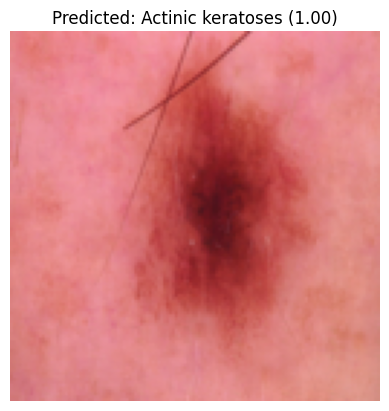

In [ ]:
if test_image_processed is not None:
    predictions = loaded_cnn_model.predict(test_image_processed)

    # Get the predicted class index and probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_probability = np.max(predictions, axis=1)[0]

    # Get the class name from the dictionary
    predicted_class_name = list(lesion_type_dict.values())[predicted_class_index]

    print(f"Prediction probabilities: {predictions}")
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: {predicted_class_name}")
    print(f"Predicted probability: {predicted_probability:.4f}")

    # Optional: Display the test image
    import matplotlib.pyplot as plt

    plt.imshow(test_image_processed[0]) # Remove the batch dimension for displaying
    plt.title(f"Predicted: {predicted_class_name} ({predicted_probability:.2f})")
    plt.axis('off')
    plt.show()